# Celeb Image Classification
This project uses OpenCV's Haar Cascade classifiers to detect faces and eyes in images. It also processes a dataset of celebrity images, crops the face if two eyes are detected, and saves the cropped images for further classification.

## Import Necessary Libraries
We begin by importing essential libraries for image processing, data handling, and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil

## Load and Display Test Image
We load a sample image (`test.webp`) from the test image folder to visualize and confirm the image's shape and content.

Image shape:(900, 1200, 3)


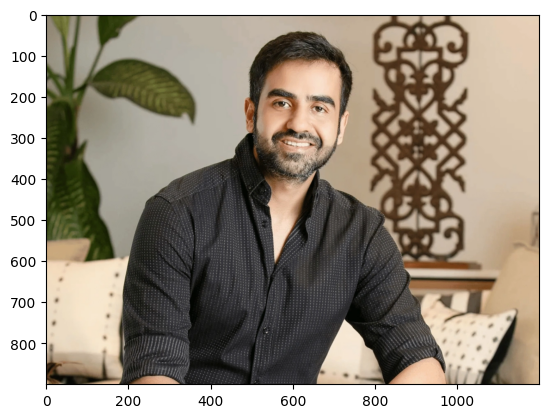

In [2]:
img = cv2.imread('test_images/test.webp')
print("Image shape:" + str(img.shape))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct display in matplotlib

## Convert Image to Grayscale
We convert the test image to grayscale, as face and eye detection using Haar Cascades works on single-channel grayscale images.

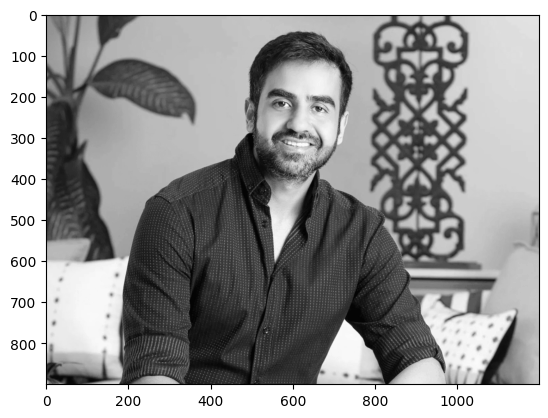

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Detect Faces in the Image
Using Haar Cascades for face detection, we detect the coordinates of any faces in the grayscale image. The function `detectMultiScale` returns a list of rectangles around detected faces.

In [4]:
face_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray,1.3,5)
print(f"Faces: {faces}")

Faces: [[479 109 273 273]]


## Draw a Rectangle Around the Detected Face
We extract the coordinates of the first detected face and draw a rectangle around it on the original image.

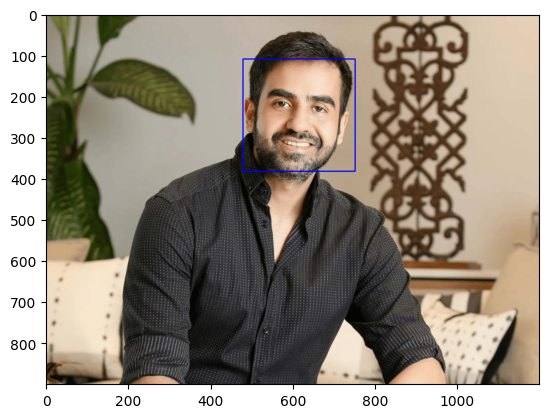

In [5]:
(x, y, w, h) = faces[0]  # Select the first detected face
face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue rectangle
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

## Detect and Highlight Eyes Within the Detected Face
For each detected face, we use the eye Haar Cascade to detect eyes. We draw rectangles around both the face and eyes.

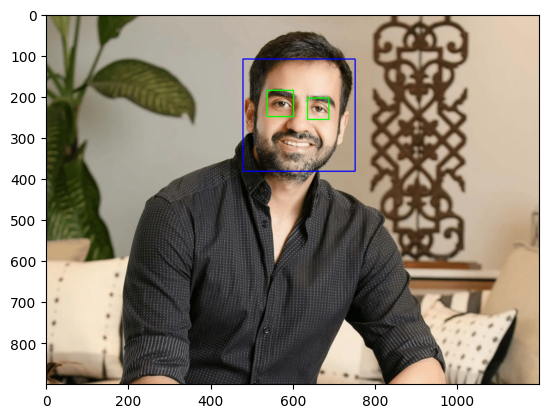

In [6]:
cv2.destroyAllWindows()

for (x, y, w, h) in faces:
    face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)  # Green rectangle for eyes

plt.figure()
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
plt.show()

## Display Region of Interest (Face with Eyes)
Finally, we display the region of interest (cropped face area with eyes) to confirm successful detection and cropping.

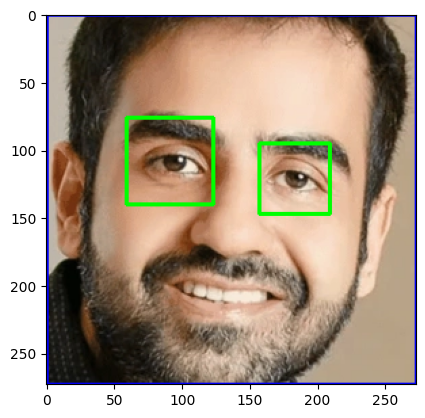

In [7]:
plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))

In [8]:
cropped_img = np.array(roi_color)
cropped_img.shape

(273, 273, 3)

In [9]:
import pywt

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

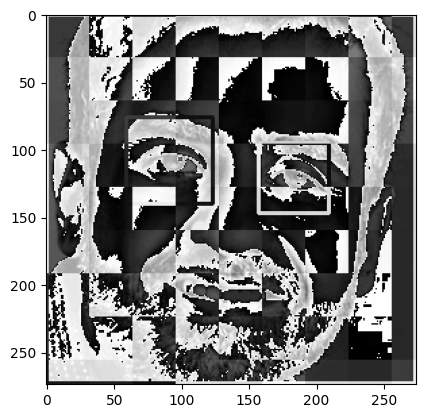

In [10]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

## Function to Crop Image if 2 Eyes are Detected
This function detects faces and eyes in a given image. If two or more eyes are found, it crops and returns the face region.

In [11]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        # If two or more eyes are detected, return cropped face
        if len(eyes) >= 2:
            return roi_color
    return None

## Test Cropping Function on Test Image
We test our `get_cropped_image_if_2_eyes` function on a sample test image.

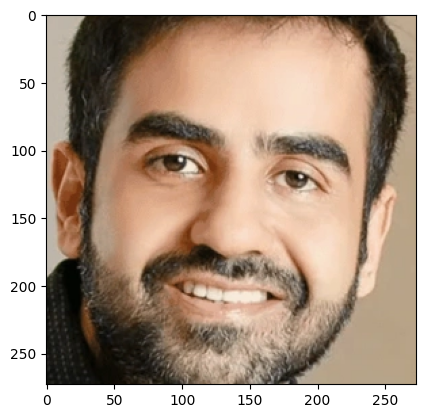

In [12]:
original_image = get_cropped_image_if_2_eyes('test_images/test.webp')
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

## Define Dataset Paths
We define the paths for the original dataset (`images_dataset`) and the folder where the cropped images will be saved (`images_dataset/cropped`).

In [13]:
path_to_data = "./images_dataset/"
path_to_cr_data = "./images_dataset/cropped/"

## Create List of Image Directories
We gather all the directories inside the dataset folder, which represent different celebrity folders.

In [14]:
img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]
print("Image directories:", img_dirs)

Image directories: ['./images_dataset/cropped', './images_dataset/lionel_messi', './images_dataset/maria_sharapova', './images_dataset/roger_federer', './images_dataset/serena_williams', './images_dataset/virat_kohli']


## Clean and Recreate Cropped Image Directory
Before processing new images, we remove any old cropped data and recreate the cropped folder.

In [15]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

## Process Each Celebrity Folder

In this step, we process the folders containing images of different celebrities. The key tasks include:
- Scanning directories
- Cropping images if a face with two eyes is detected
- Saving the cropped images in a separate folder

The following functions are created to organize this process:
- `create_directory_if_not_exists`: Create a directory if it doesn't exist.
- `process_images_for_celebrity`: Process each image for a celebrity and save cropped images.
- `process_all_celebrities`: Process all celebrity folders in the dataset.

### Function: Create Directory If Not Exists

In [16]:
def create_directory_if_not_exists(path):
    """Check if a directory exists, create it if not."""
    if not os.path.exists(path):
        os.makedirs(path)

### Function: Process Images for a Celebrity

In [17]:
def process_images_for_celebrity(img_dir, cropped_image_dirs, celebrity_file_names_dict):
    """Process images for a single celebrity by cropping faces with two eyes."""
    count = 1
    celebrity_name = os.path.basename(img_dir)
    print(f"Processing images for: {celebrity_name}")

    # Initialize list for storing file names of cropped images for this celebrity
    celebrity_file_names_dict[celebrity_name] = []

    # Iterate over all images in the celebrity's folder
    for entry in os.scandir(img_dir):
        if entry.is_file():
            cropped_img = get_cropped_image_if_2_eyes(entry.path)
            
            if cropped_img is not None:
                # Define the path for saving the cropped images
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                create_directory_if_not_exists(cropped_folder)  # Ensure folder exists
                
                # Save the cropped image
                cropped_file_name = f"{celebrity_name}_{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                cv2.imwrite(cropped_file_path, cropped_img)
                
                # Update directories and file lists
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                cropped_image_dirs.append(cropped_folder)
                
                print(f"Saved cropped image: {cropped_file_path}")
                count += 1

### Function: Process All Celebrities

In [18]:
def process_all_celebrities(path_to_data, path_to_cr_data):
    """Process all celebrity folders and crop faces with two eyes."""
    img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]
    cropped_image_dirs = []
    celebrity_file_names_dict = {}

    # Process each directory containing celebrity images
    for img_dir in img_dirs:
        process_images_for_celebrity(img_dir, cropped_image_dirs, celebrity_file_names_dict)

    return cropped_image_dirs, celebrity_file_names_dict

### Clean Cropped Directory Before Processing
We clean the folder containing cropped images before processing new images.

In [19]:
def clean_cropped_directory(path_to_cr_data):
    """Clean and recreate the cropped image directory."""
    if os.path.exists(path_to_cr_data):
        shutil.rmtree(path_to_cr_data)
    os.mkdir(path_to_cr_data)

## Execute the Cropping Process
We now call the functions to process all celebrity images and save the cropped faces.

In [20]:
# Clean the cropped directory before processing
clean_cropped_directory(path_to_cr_data)

# Process all celebrity images and save cropped versions
cropped_image_dirs, celebrity_file_names_dict = process_all_celebrities(path_to_data, path_to_cr_data)

# Display the results
print(f"Cropped image directories: {cropped_image_dirs}")
print(f"Celebrity file names dictionary: {celebrity_file_names_dict}")

Processing images for: cropped
Processing images for: lionel_messi
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_1.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_2.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_3.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_4.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_5.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_6.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_7.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_8.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_9.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_10.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_11.png
Saved cropped image: ./images_dataset/cropped/lionel_messi\lionel_messi_1

## Generate a Dictionary of Cropped Image File Names
Iterate through each celebrity's cropped image directory and collect the paths of the cropped images. Save these paths in a dictionary where the keys are celebrity names and the values are lists of image file paths.

In [21]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]  # Extract celebrity name from directory path
    file_list = []
    for entry in os.scandir(img_dir):  # Scan the directory for image files
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list  # Save file paths in the dictionary

# Display the dictionary
celebrity_file_names_dict

{'lionel_messi': ['./images_dataset/cropped/lionel_messi\\lionel_messi_1.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_10.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_11.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_12.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_13.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_14.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_15.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_16.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_17.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_18.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_19.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_2.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_20.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_21.png',
  './images_dataset/cropped/lionel_messi\\lionel_messi_22.png',
  './images_dataset/croppe

## Create a Class Dictionary
Create a dictionary that maps each celebrity's name to a unique numerical label. This will be used as the target variable (labels) for the classification model.

In [22]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count  # Assign a unique integer label to each celebrity
    count += 1

# Display the class dictionary
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

## Prepare Training Data
For each celebrity, read the cropped images, resize them, and perform a wavelet transformation for feature extraction. The features are stacked vertically and stored in the `X` array, while the corresponding labels are stored in `y`.

In [23]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)  # Read the image
        scalled_raw_img = cv2.resize(img, (32, 32))  # Resize the image to 32x32 pixels

        img_har = w2d(img, 'db1', 5)  # Apply wavelet transform
        scalled_img_har = cv2.resize(img_har, (32, 32))  # Resize the wavelet transformed image to 32x32 pixels

        # Stack the raw image and wavelet transformed image features vertically
        combined_img = np.vstack((
            scalled_raw_img.reshape(32*32*3, 1),  # Flatten the raw image and reshape into a column vector
            scalled_img_har.reshape(32*32, 1)     # Flatten the wavelet transformed image and reshape
        ))

        X.append(combined_img)  # Add the combined features to the dataset
        y.append(class_dict[celebrity_name])  # Add the corresponding label

## Check the Length of the First Image's Feature Vector
The feature vector for each image should have a length of 4096 (32x32x3 for the raw image and 32x32 for the wavelet-transformed image).


In [24]:
32*32*3 + 32*32  # Expected feature vector length is 4096

4096

## View the First Image's Feature Vector
Display the feature vector for the first image to inspect the combined feature data.

In [25]:
X[0]

array([[100],
       [129],
       [140],
       ...,
       [237],
       [234],
       [232]], dtype=uint8)

## View the Label of the First Image
Display the label (class) of the first image in the dataset to ensure the correct mapping of features to labels.

In [26]:
y[0]

0

## Reshape the Feature Matrix
Convert the list of feature vectors (`X`) into a NumPy array and reshape it into a matrix with dimensions `(number of images, 4096)`.

In [27]:
X = np.array(X).reshape(len(X), 4096).astype(float)  # Reshape X to have 4096 columns (features)
X.shape  # Output the shape of the feature matrix

(187, 4096)

## Building the model
We will use SVM with rbf kernel tuned with heuristic finetuning

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7659574468085106

In [30]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.70      0.74        10
           1       0.67      0.75      0.71         8
           2       0.50      0.50      0.50         6
           3       0.90      0.82      0.86        11
           4       0.85      0.92      0.88        12

    accuracy                           0.77        47
   macro avg       0.74      0.74      0.74        47
weighted avg       0.77      0.77      0.77        47



In [31]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [32]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [33]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

C:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\laksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\laksh\AppData\Local\Programs\Python\P

,model,best_score,best_params
0,svm,0.764286,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.628571,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.771429,{'logisticregression__C': 1}


In [34]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, multi_class='auto',
                                     solver='liblinear'))])}

In [35]:
best_estimators['svm'].score(X_test,y_test)

0.7872340425531915

In [36]:
best_estimators['random_forest'].score(X_test,y_test)

0.6808510638297872

In [37]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.7446808510638298

In [38]:
best_clf = best_estimators['svm']

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[ 8,  0,  1,  0,  1],
       [ 1,  6,  0,  1,  0],
       [ 1,  1,  3,  1,  0],
       [ 0,  0,  1, 10,  0],
       [ 1,  1,  0,  0, 10]])

Text(95.72222222222221, 0.5, 'Truth')

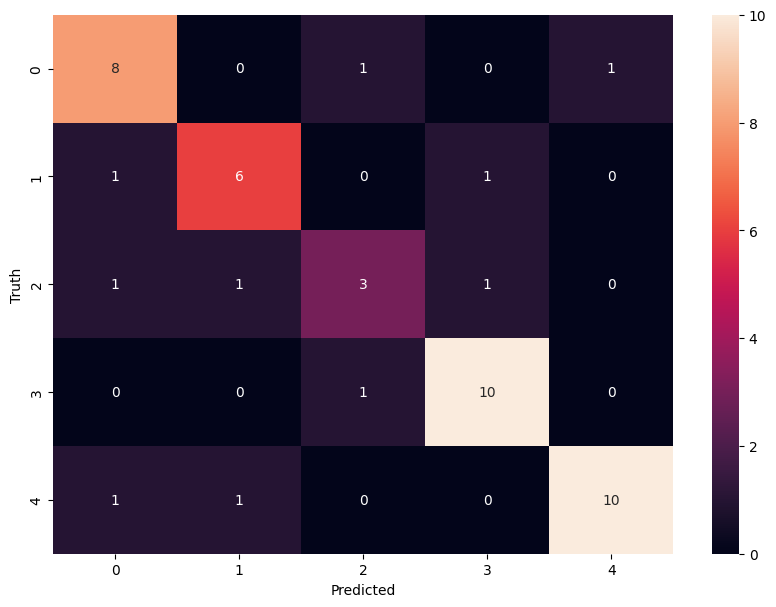

In [40]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [41]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [42]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [44]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))